## Sea Navigation

In [53]:
import pandas as pd
import math
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import numpy
import random
import copy
import matplotlib.pyplot as plt

In [54]:
data_points = pd.read_csv('../sea_navigation.csv')
data_points.head()

,x,y
0,10,0
1,20,10
2,20,20
3,40,30
4,40,80


In [55]:
data_points_list = data_points.values.tolist()
data_points_list

[[10, 0],
 [20, 10],
 [20, 20],
 [40, 30],
 [40, 80],
 [90, 50],
 [80, 40],
 [30, 80],
 [80, 60],
 [50, 80],
 [80, 100],
 [70, 20],
 [30, 50],
 [50, 60],
 [80, 50],
 [100, 50]]

In [56]:
len(data_points)

16

### Objective Functions

In [57]:
def calculate_distance(origin_city, destiny_city):
  X1 = origin_city[0]
  Y1 = origin_city[1]
  X2 = destiny_city[0]
  Y2 = destiny_city[1]
  return math.sqrt(((X1-X2)**2) + (Y1-Y2)**2)

In [58]:
def distance_travelled(individual_original):

  individual = copy.deepcopy(individual_original)
  individual.append(individual[0])
  total_distance = 0

  for index, city_number in enumerate(individual):
    origin_city_points = data_points_list[city_number]
    destiny_city_points = data_points_list[individual[index+1]]
    total_distance += calculate_distance(origin_city_points, destiny_city_points)

    if index == len(individual) - 2:
      break

  return total_distance,

In [59]:
distance_travelled([0,1,2,13,15,9,7,11,10,8,6,14,12,3,4,5])

(701.185462744394,)

## Restrictions

In [60]:
def west_forbidden(individual_original):

  individual = copy.deepcopy(individual_original)
  individual.append(individual[0])

  for index, city_number in enumerate(individual):
    origin_city_points = data_points_list[city_number]
    destiny_city_points = data_points_list[individual[index+1]]

    if index == len(individual) - 2:
      break

    if origin_city_points[0] > destiny_city_points[0] and origin_city_points[1] == destiny_city_points[1]:
      return False
  return True

In [61]:
west_forbidden([0,1,2,3,4,13,6,7,8,9,10,11,12,5,14,15])

False

In [62]:
def west_penalty(individual_original):

  west_penalty = 0
  individual = copy.deepcopy(individual_original)
  individual.append(individual[0])

  for index, city_number in enumerate(individual):
    origin_city_points = data_points_list[city_number]
    destiny_city_points = data_points_list[individual[index+1]]

    if origin_city_points[0] == destiny_city_points[0] and origin_city_points[1] < destiny_city_points[1]:
      west_penalty += (calculate_distance(origin_city_points, destiny_city_points)) ** 2
    else:
      west_penalty += calculate_distance(origin_city_points, destiny_city_points)

    if index == len(individual) - 2:
      break

  return west_penalty

In [63]:
west_penalty([0,1,2,3,4,13,6,7,8,9,10,11,12,5,14,15])

3208.4918027761755

## DEAP Optimization Methods

In [64]:
import copy
import random

def uniform_based_order(individual_1, individual_2, shuffle_size=5):
    """
    uniform based order crossover

    :param individual_1:
    :param individual_2:
    :param shuffle_size:
    :return: two children
    """

    child_1 = copy.deepcopy(individual_1)
    child_2 = copy.deepcopy(individual_2)

    size = min(len(child_1), len(child_2))
    if size < shuffle_size:
        shuffle_size = size - 1

    index = [*range(size)]
    bit_mask = set(random.sample(index, shuffle_size))

    shuffle_1 = [individual_1[idx] for idx in bit_mask]
    shuffle_2 = [individual_2[idx] for idx in bit_mask]

    inv_bit_mask = set(index) - bit_mask

    parent1 = [individual_1[i] for i in inv_bit_mask]
    parent2 = [individual_2[i] for i in inv_bit_mask]

    order_shuffle_1 = set(shuffle_1)
    order_shuffle_2 = set(shuffle_2)

    can_shuffle = order_shuffle_1 & order_shuffle_2
    remain_shuffle = order_shuffle_1 ^ order_shuffle_2

    # create order from data
    order_shuffle_1 = [x for x in shuffle_1 if x in can_shuffle]
    order_shuffle_2 = [x for x in shuffle_2 if x in can_shuffle]

    parent1 = [x for x in parent1 if x in remain_shuffle]
    parent2 = [x for x in parent2 if x in remain_shuffle]

    order_shuffle_1 += parent1
    order_shuffle_2 += parent2

    i = 0
    for idx in bit_mask:
        child_1[idx] = order_shuffle_2[i]
        child_2[idx] = order_shuffle_1[i]
        i += 1

    return child_1, child_2

In [65]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

C:\Users\borges\AppData\Local\Programs\Python\optimization_cases\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\borges\AppData\Local\Programs\Python\optimization_cases\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [66]:
toolbox = base.Toolbox()
toolbox.register("random_unique_int", random.sample, range(0,len(data_points)), len(data_points))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.random_unique_int)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", distance_travelled)
toolbox.decorate("evaluate", tools.DeltaPenalty(west_forbidden, 1, west_penalty))

toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.3)
toolbox.register("select", tools.selTournament, tournsize=4)

In [67]:
pop = toolbox.population(n=500)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

In [68]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.9, mutpb=0.3, ngen=250, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg    	std    	min    	max    
0  	500   	1235.68	1048.46	587.408	6827.91
1  	459   	980.782	721.662	506.56 	5559.61
2  	459   	954.98 	709.803	540.841	6878.24
3  	465   	928.709	720.475	540.841	6882.32
4  	466   	936.972	739.011	528.601	4663.55
5  	470   	869.632	575.675	508.048	4398.1 
6  	462   	909.024	702.944	508.048	6931.98
7  	466   	848.431	591.681	454.606	5659.6 
8  	462   	911.13 	755.735	446.967	7142.59
9  	469   	971.222	812.905	446.967	5805.38
10 	459   	868.849	718.836	446.967	6491.48
11 	454   	888.389	784.155	434.01 	6738.84
12 	469   	845.535	627.327	434.01 	4633.11
13 	461   	867.531	700.952	430.286	6888.77
14 	466   	868.715	743.453	430.286	5222.42
15 	476   	880.72 	745.407	419.706	5683.13
16 	458   	885.155	770.794	422.238	4968.95
17 	467   	870.929	745.939	429.878	4500.16
18 	456   	839.322	692.688	423.844	5131.66
19 	454   	909.524	851.662	415.181	6767.35
20 	463   	873.331	754.817	388.04 	4771.61
21 	455   	867.763	773.88 	389.822	5715.58
22 	462   	

In [69]:
# Best result
print("Best Individual - Order of points:")
print(hof[0])

# Check for restriction function
print("Restrictions check")
print(west_forbidden(hof[0]))
print(west_penalty(hof[0]))


# Objective function of best individual
print("Best individual distance:")
distance_travelled(hof[0])

Best Individual - Order of points:
[4, 9, 10, 8, 14, 5, 15, 6, 11, 3, 1, 0, 2, 12, 13, 7]
Restrictions check
True
349.4544631766538
Best individual distance:


(349.4544631766538,)

## Ploting the order of points!

In [70]:
hof[0]

[4, 9, 10, 8, 14, 5, 15, 6, 11, 3, 1, 0, 2, 12, 13, 7]

In [71]:
hof_city = pd.DataFrame([[data_points['x'][index], data_points['y'][index]]  for index in hof[0]], columns=['x', 'y'])
hof_city = hof_city._append(hof_city.iloc[0])
hof_city

,x,y
0,40,80
1,50,80
2,80,100
3,80,60
4,80,50
5,90,50
6,100,50
7,80,40
8,70,20
9,40,30


In [72]:
data_points

,x,y
0,10,0
1,20,10
2,20,20
3,40,30
4,40,80
5,90,50
6,80,40
7,30,80
8,80,60
9,50,80


[4, 9, 10, 8, 14, 5, 15, 6, 11, 3, 1, 0, 2, 12, 13, 7]
(349.4544631766538,)


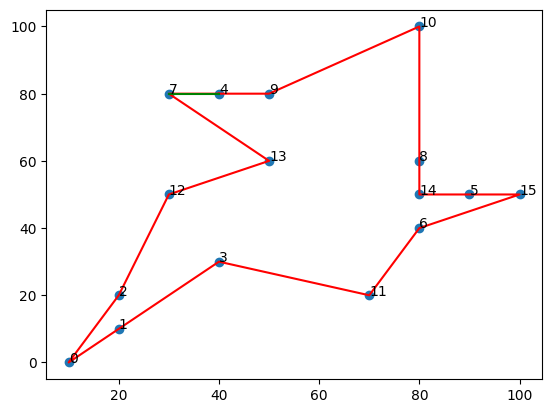

In [75]:
print(hof[0])
print(distance_travelled(hof[0]))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(data_points['x'], data_points['y'])
plt.plot(hof_city['x'], hof_city['y'], 'r')
for index, (x,y) in enumerate(data_points.values):
    ax.annotate(str(index), xy=(x,y))
plt.plot(hof_city['x'][-2:], hof_city['y'][-2:], 'g')